In [1]:
# Import main packages
import sys, os
sys.path.insert(1, os.path.abspath('..') )
from ECO import diagnostics as eco
from ECO.utils import config_parser, open_datasets, get_namelist
import xarray as xr
import xgcm
import numpy as np

# Import matplotlib for plotting and functions to override default values
import matplotlib.pyplot as plt
#from ECOanalysis import update_plotstyle, cmap_OB
#cmap_OB=cmap_OB(); update_plotstyle()

In [2]:
exp_prefix = ['EXP00','EXP00_l']       # Import all files with this prefix
exp_suffix = '_1d10'#,'_1d10_NoGM']#,'_1d10_HDiff','_1d10_NoGM_HDiff',]
ds = open_datasets(exp_prefix, exp_suffix, components = ['all'])

In [3]:
# get base configuration of EXP00
kwargs={}
for exp in exp_prefix: kwargs[exp+exp_suffix] = config_parser(exp)
#if kwargs_sim['get_namelist']: kwargs_sim['namelist'] = get_namelist(path = kwargs_proc['path_nemo'])

# define xgcm configuration based on dataset metrics
_metrics = {('X',): ['e1tm', 'e1um', 'e1vm', 'e1fm'],
     ('Y',): ['e2tm', 'e2um', 'e2vm', 'e2fm'],
     ('Z',): ['e3tm', 'e3um', 'e3vm', 'e3wm']}

grid = {exp: xgcm.Grid(ds[exp], metrics=_metrics, periodic=False) for exp in ds} # define xgcm grid
grid_ops = {exp: eco.Grid_ops(grid[exp], maskargs={'mask':'nan'}) for exp in ds} # define gridoperations.
grid = {exp: grid_ops[exp]._update({'Z':ds[exp]['e3tm_1d']}) for exp in ds}
        
properties= {exp: eco.Properties(grid_ops[exp], {'X': ds[exp].glamt, 'Y': ds[exp].gphit, 'Z': ds[exp].depth_1d}, eos_properties=kwargs[exp][2]['eos']) for exp in ds}
energetics= {exp: eco.Energetics(grid_ops[exp], properties[exp]) for exp in ds}

Using processing configuration base.yml
Using processing configuration base.yml


In [4]:
exp0='EXP00_1d10'
exp1='EXP00_l_1d10'

In [5]:
depth_new = {exp: -(grid[exp].cumsum(ds[exp].e3wm,'Z') - 0.5*ds[exp].e3tm.mean('t').isel({'z_c':0})) for exp in ds}
depth_new_1d = {exp: depth_new[exp].mean(['t','x_c','y_c']) for exp in ds}

properties_new= {exp: eco.Properties(grid_ops[exp], {'X': ds[exp].glamt, 'Y': ds[exp].gphit, 'Z': depth_new_1d[exp]}, eos_properties=kwargs[exp][2]['eos']) for exp in ds}

energetics_new= {exp: eco.Energetics(grid_ops[exp], properties_new[exp]) for exp in ds}


In [14]:
for exp in ds:
    print(f'\nExperiment {exp}\n' )
    maskargs = {'mask':'usr_def','mask_values':ds[exp].mask_bd_t}
    z_v = properties[exp].global_mean(ds[exp].depth)[0].values
    z_0 = energetics[exp].center_of_gravity_classical(ds[exp].rho_gm)[0].values
    z_0b = energetics[exp].center_of_gravity_classical(ds[exp].rho_gm, boussinesq=True)[0].values

    zg_v = energetics[exp].center_of_gravity_h(ds[exp].to, ds[exp].so, ds[exp].depth, Z_r = z_v)[0].values
    zg_0 = energetics[exp].center_of_gravity_h(ds[exp].to, ds[exp].so, ds[exp].depth, Z_r = z_0)[0].values
    zg_0b = energetics[exp].center_of_gravity_h(ds[exp].to, ds[exp].so, ds[exp].depth, Z_r = z_0b)[0].values

    print(f'Depth centered metric\n-------------------------------')
    print(f'z_v: {z_v}            |   zgb(z_v): {zg_v}')
    print(f'z_g0(<rho>): {z_0}   |   zgb(z_g0): {zg_0}')
    print(f'z_g0b(<rho>): {z_0b}   |   zgb(z_g0b): {zg_0b}')

    z_v_og = properties_new[exp].global_mean(depth_new[exp])[0].values
    z_0_og = energetics_new[exp].center_of_gravity_classical(ds[exp].rho_gm)[0].values
    z_0b_og = energetics_new[exp].center_of_gravity_classical(ds[exp].rho_gm, boussinesq=True)[0].values

    zg_v_og = energetics_new[exp].center_of_gravity_h(ds[exp].to, ds[exp].so, depth_new[exp], Z_r = z_v_og)[0].values
    zg_0_og = energetics_new[exp].center_of_gravity_h(ds[exp].to, ds[exp].so, depth_new[exp], Z_r = z_0_og)[0].values
    zg_0b_og = energetics_new[exp].center_of_gravity_h(ds[exp].to, ds[exp].so, depth_new[exp], Z_r = z_0b_og)[0].values

    print('')
    print(f'Depth original metric\n-------------------------------')
    print(f'z_v: {z_v_og}            |   zgb(z_v): {zg_v_og}')
    print(f'z_g0(<rho>): {z_0_og}    |   zgb(z_g0): {zg_0_og}')
    print(f'z_g0b(<rho>): {z_0b_og}   |   zgb(z_g0b): {zg_0b_og}')


Experiment EXP00_1d10

Depth centered metric
-------------------------------
z_v: -2000.000000551862            |   zgb(z_v): -0.3710778297655469
z_g0(<rho>): -2000.2040836930853   |   zgb(z_g0): -0.37069547184645696
z_g0b(<rho>): -2004.004940859591   |   zgb(z_g0b): -0.36357318721751763

Depth original metric
-------------------------------
z_v: -1997.0726052402745            |   zgb(z_v): -0.3705097234459686
z_g0(<rho>): -1997.2309222601225    |   zgb(z_g0): -0.37021318547436693
z_g0b(<rho>): -2001.0261297221646   |   zgb(z_g0b): -0.3631033082232367

Experiment EXP00_l_1d10

Depth centered metric
-------------------------------
z_v: -2000.0000002101447            |   zgb(z_v): -0.24055427673304433
z_g0(<rho>): -1999.9970126393785   |   zgb(z_g0): -0.24055992233817616
z_g0b(<rho>): -2003.776402064277   |   zgb(z_g0b): -0.23341801943367463

Depth original metric
-------------------------------
z_v: -1997.0726036538465            |   zgb(z_v): -0.24025142745384975
z_g0(<rho>): -1997.02

In [9]:
maskargs = {'mask':'usr_def','mask_values':ds[exp0].mask_bd_t}
for exp in ds:
    print(properties[exp].global_mean(ds[exp].depth).mean('t').values)
    print(energetics[exp].center_of_gravity_classical(ds[exp].rho_gm).mean('t').values)
    print(energetics[exp].center_of_gravity_classical(ds[exp].rho_gm, boussinesq=True).mean('t').values)

-2000.000000588436
-2000.2031264222817
-2003.9974935394655
-2000.0000005903755
-2000.2031018798218
-2003.9972430719188


In [13]:
maskargs = {'mask':'usr_def','mask_values':ds[exp0].mask_bd_t}
for exp in ds:
    print(properties_new[exp].global_mean(depth_new[exp]).mean('t').values)
    print(energetics_new[exp].center_of_gravity_classical(ds[exp].rho_gm).mean('t').values)
    print(energetics_new[exp].center_of_gravity_classical(ds[exp].rho_gm, boussinesq=True).mean('t').values)

1997.0726053891608
1997.2299656363064
2001.0186926945537
1997.0726053938781
1997.2299223726632
2001.018423806064


In [5]:
deptht_0 = ds[exp0].gdept_0[:,10,10]
depthw_0 = ds[exp0].gdepw_0[:,10,10]
e3t = ds[exp0].e3tm[0,:,10,10]
e3w = ds[exp0].e3wm[0,:,10,10]

In [20]:
print(depthw_0.values[1:]-depthw_0.values[:-1])
print(e3t.values)

[ 10.          10.          10.          10.          10.
  10.45485785  11.48753579  12.73225271  14.23138887  16.03526985
  18.20341825  20.80589272  23.92466397  27.65494356  32.1063352
  37.40361864  43.68690268  51.11080041  59.84219608  70.05610698
  81.92912626  95.6300066  111.30716033 129.07325829 148.98772643
 171.03872522 195.1270181  221.05475129 248.52227165 277.1354357
 306.42433028 335.87216964 364.9509079  393.15851021 420.05241856]
[ 10.0005722   10.0005722   10.0005722   10.0005722   10.0005722
  10.45545673  11.48819351  12.73298168  14.23220348  16.03618813
  18.20446014  20.80708313  23.92603302  27.65652657  32.10817337
  37.4057579   43.68940353  51.11372757  59.84562302  70.06011963
  81.933815    95.63548279 111.31352997 129.0806427  148.9962616
 171.04852295 195.13818359 221.06739807 248.53649902 277.15130615
 306.44186401 335.89138794 364.97180176 393.18099976 420.07647705
          nan]


In [17]:
print(deptht_0.values[1:]-deptht_0.values[:-1])
print(e3w.values)

[ 10.          10.          10.          10.          10.11013453
  10.9470623   12.0809129   13.44707341  15.09174701  17.06969501
  19.44553681  22.29511561  25.70686384  29.78306295  34.64083899
  40.41266908  47.24609425  55.30224923  64.75274147  75.77436594
  88.5411638  103.21347185 119.92391554 138.7608106  159.75015006
 182.8381807  207.87732717 234.61862159 262.71353712 291.72701293
 321.16156313 350.49008671 379.19299885 406.79425407 432.89110421]
[ 10.0005722   10.0005722   10.0005722   10.0005722   10.0005722
  10.11071968  10.94769001  12.08160591  13.44784546  15.09261322
  17.0706749   19.44665337  22.29639626  25.70833969  29.78477287
  34.6428299   40.41498947  47.248806    55.30542374  64.7564621
  75.77871704  88.54624176 103.21939087 119.93079376 138.76876831
 159.75930786 182.84866333 207.88923645 234.63206482 262.72857666
 291.74371338 321.17993164 350.51013184 379.21469116 406.8175354
          nan]


In [9]:
e3t_top = deptht_0.values-depthw_0.values
e3t_bot = depthw_0.values[1:]-deptht_0.values[:-1]
print(e3t_top)
print(e3t_bot)

[  5.           5.           5.           5.           5.
   5.11013453   5.60233897   6.19571608   6.91053678   7.77089492
   8.80532008  10.04743864  11.53666152  13.3188614   15.44698079
  17.98148459  20.99053502  24.5497266   28.74117542  33.65172081
  39.36997977  45.98201732  53.56548257  62.18223778  71.86979008
  82.6322137   94.43166919 107.18197825 120.74584855 134.93711403
 149.52869126 164.26592411 178.88384119 193.12593214 206.76167601
 219.60036165]
[  5.           5.           5.           5.           5.
   5.34472333   5.88519682   6.53653663   7.32085209   8.26437493
   9.39809818  10.75845409  12.38800245  14.33608216  16.65935441
  19.42213405  22.69636765  26.56107381  31.10102067  36.40438617
  42.55914649  49.64798929  57.74167776  66.89102051  77.11793635
  88.40651151 100.69534892 113.87277304 127.77642309 142.19832167
 156.89563902 171.60624552 186.06706671 200.03257807 213.29074256]


In [30]:
print(e3t_top[:-1]+e3t_bot)
print(e3t.values)

[ 10.          10.          10.          10.          10.
  10.45485785  11.48753579  12.73225271  14.23138887  16.03526985
  18.20341825  20.80589272  23.92466397  27.65494356  32.1063352
  37.40361864  43.68690268  51.11080041  59.84219608  70.05610698
  81.92912626  95.6300066  111.30716033 129.07325829 148.98772643
 171.03872522 195.1270181  221.05475129 248.52227165 277.1354357
 306.42433028 335.87216964 364.9509079  393.15851021 420.05241856]
[ 10.0005722   10.0005722   10.0005722   10.0005722   10.0005722
  10.45545673  11.48819351  12.73298168  14.23220348  16.03618813
  18.20446014  20.80708313  23.92603302  27.65652657  32.10817337
  37.4057579   43.68940353  51.11372757  59.84562302  70.06011963
  81.933815    95.63548279 111.31352997 129.0806427  148.9962616
 171.04852295 195.13818359 221.06739807 248.53649902 277.15130615
 306.44186401 335.89138794 364.97180176 393.18099976 420.07647705
          nan]


In [10]:
print(e3t_top[1:]+e3t_bot)
print(e3w.values)

[ 10.          10.          10.          10.          10.11013453
  10.9470623   12.0809129   13.44707341  15.09174701  17.06969501
  19.44553681  22.29511561  25.70686384  29.78306295  34.64083899
  40.41266908  47.24609425  55.30224923  64.75274147  75.77436594
  88.5411638  103.21347185 119.92391554 138.7608106  159.75015006
 182.8381807  207.87732717 234.61862159 262.71353712 291.72701293
 321.16156313 350.49008671 379.19299885 406.79425407 432.89110421]
[ 10.0005722   10.0005722   10.0005722   10.0005722   10.0005722
  10.11071968  10.94769001  12.08160591  13.44784546  15.09261322
  17.0706749   19.44665337  22.29639626  25.70833969  29.78477287
  34.6428299   40.41498947  47.248806    55.30542374  64.7564621
  75.77871704  88.54624176 103.21939087 119.93079376 138.76876831
 159.75930786 182.84866333 207.88923645 234.63206482 262.72857666
 291.74371338 321.17993164 350.51013184 379.21469116 406.8175354
          nan]


ttrd_xad 6.025954854861909e-10
ttrd_yad 1.1289194942996497e-09
ttrd_zad -1.7315165099381277e-09
ttrd_ldf 2.122349521215934e-20
ttrd_zdf -8.028802255410237e-20
ttrd_qns -1.0815933973217213e-08
ttrd_qsr 1.0969915851702464e-08
SUM:  1.5398034827389738e-10


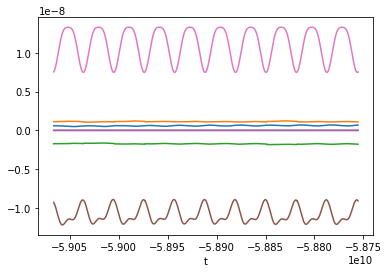

In [6]:
sumt = 0
Zeros = xr.zeros_like(ds[exp0].e3tm)
Zeros[:,0] +=  1
for var in ds[exp0]:
    if 'tt' in var:
        if ds[exp0][var].dims == ('t','y_c','x_c'):
            p_3d = ds[exp0][var].expand_dims({'z_c':ds[exp0].z_c},axis=1) * Zeros
            p = properties[exp0].global_mean(p_3d, Vmask=ds[exp0].mask_bd_t)#[0].values
        else:
            p = properties[exp0].global_mean(ds[exp0][var], Vmask=ds[exp0].mask_bd_t)#[0].values
        sumt += p
        print(var, p.mean('t').values)
        p.plot()
print('SUM: ', sumt.mean('t').values)

strd_xad 1.1391766600409801e-12
strd_yad 5.0681689727426145e-11
strd_zad -5.1820762150138246e-11
strd_ldf 2.68401133247956e-21
strd_zdf 1.2282821462744137e-21
strd_cdt 6.489686750801189e-12
SUM:  6.4897909920423655e-12


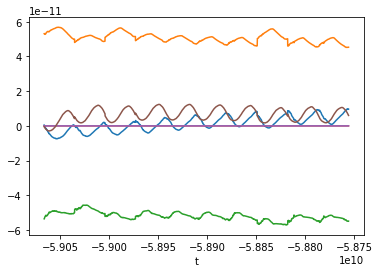

In [21]:
sums = 0
Zeros = xr.zeros_like(ds[exp0].e3tm)
Zeros[:,0] +=  1
for var in ds[exp0]:
    if 'st' in var:
        if ds[exp0][var].dims == ('t','y_c','x_c'):
            p_3d = ds[exp0][var].expand_dims({'z_c':ds[exp0].z_c},axis=1) * Zeros
            p = properties[exp0].global_mean(p_3d, Vmask=ds[exp0].mask_bd_t)#[0].values
        else:
            p = properties[exp0].global_mean(ds[exp0][var], Vmask=ds[exp0].mask_bd_t)#[0].values
        sums += p
        print(var, p.mean('t').values)
        p.plot()
print('SUM: ', sums.mean('t').values)

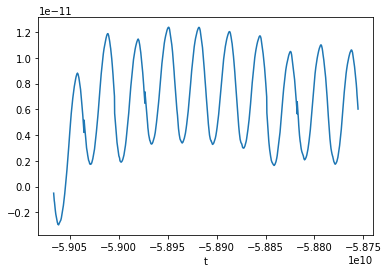

In [22]:
sum.plot()

In [24]:
maskargs_t={exp: {'mask':'usr_def','mask_values':ds[exp].mask_bd_t} for exp in ds}
maskargs_w={exp: {'mask':'usr_def','mask_values':ds[exp].mask_bd_w} for exp in ds}

drho_W_star ={exp: grid_ops[exp]._shift_position((properties[exp].horizontal_anomaly(ds[exp].rho_s-1026)),'W',
                maskargs=maskargs_w[exp]) for exp in ds}
z_conv_star_h={exp: (1/1026*drho_W_star[exp]*ds[exp].wo*ds[exp].e3wm) 
                              for exp in ds}

C_star_h={exp: (grid_ops[exp]._shift_position(z_conv_star_h[exp],'T',
                maskargs=maskargs_t[exp])/ds[exp].e3tm).compute() for exp in ds}
C_star_rolling={exp: C_star_h[exp].fillna(0).rolling({'x_c':2,'y_c':2}).mean(['x_c','y_c']) for exp in ds}


drho_W ={exp: grid_ops[exp]._shift_position((ds[exp].rho_s-1026),'W',
                maskargs=maskargs_w[exp]) for exp in ds}
z_conv_h={exp: (1/1026*drho_W[exp]*ds[exp].wo*ds[exp].e3wm) 
                              for exp in ds}

C_h={exp: (grid_ops[exp]._shift_position(z_conv_h[exp],'T',
                maskargs=maskargs_t[exp])/ds[exp].e3tm).compute() for exp in ds}
C_rolling={exp: C_h[exp].fillna(0).rolling({'x_c':2,'y_c':2}).mean(['x_c','y_c']) for exp in ds}


In [10]:
xr.open_mfdataset('../data/preprocessed/EXP00/EXP00_1d10/EXP00_1d10*')

<xarray.Dataset>
Dimensions:               (z_f: 36, t: 3600, axis_nbounds: 2, y_c: 40, x_c: 20,
                           z_c: 36, x_f: 20, y_f: 40)
Coordinates: (12/20)
  * z_f                   (z_f) float64 -0.5 0.5 1.5 2.5 ... 31.5 32.5 33.5 34.5
    time_centered         (t) object dask.array<chunksize=(360,), meta=np.ndarray>
  * t                     (t) object 0001-01-01 12:00:00 ... 0010-12-30 12:00:00
  * x_c                   (x_c) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * y_c                   (y_c) int64 0 1 2 3 4 5 6 7 ... 33 34 35 36 37 38 39
  * z_c                   (z_c) int64 0 1 2 3 4 5 6 7 ... 29 30 31 32 33 34 35
    ...                    ...
    gphit                 (y_c, x_c) float64 dask.array<chunksize=(40, 20), meta=np.ndarray>
    gphiu                 (y_c, x_f) float64 dask.array<chunksize=(40, 20), meta=np.ndarray>
    gphiv                 (y_f, x_c) float64 dask.array<chunksize=(40, 20), meta=np.ndarray>
    gphif                 (y_f, x_f) float64 dask.array<chunksize=(40, 20), meta=np.ndarray>
    gdept_0               (z_c, y_c, x_c) float64 dask.array<chunksize=(36, 40, 20), meta=np.ndarray>
    gdepw_0               (z_f, y_c, x_c) float64 dask.array<chunksize=(36, 40, 20), meta=np.ndarray>
Dimensions without coordinates: axis_nbounds
Data variables: (12/73)
    depthw_bounds         (t, z_f, axis_nbounds) float32 dask.array<chunksize=(360, 36, 2), meta=np.ndarray>
    time_centered_bounds  (t, axis_nbounds) object dask.array<chunksize=(360, 2), meta=np.ndarray>
    t_bounds              (t, axis_nbounds) object dask.array<chunksize=(360, 2), meta=np.ndarray>
    e3w                   (t, z_f, y_c, x_c) float32 dask.array<chunksize=(360, 36, 40, 20), meta=np.ndarray>
    woce                  (t, z_f, y_c, x_c) float32 dask.array<chunksize=(360, 36, 40, 20), meta=np.ndarray>
    woce_eiv              (t, z_f, y_c, x_c) float32 dask.array<chunksize=(360, 36, 40, 20), meta=np.ndarray>
    ...                    ...
    top_level             (t, y_c, x_c) int32 dask.array<chunksize=(360, 40, 20), meta=np.ndarray>
    bottom_level          (t, y_c, x_c) int32 dask.array<chunksize=(360, 40, 20), meta=np.ndarray>
    stiffness             (t, y_c, x_c) float64 dask.array<chunksize=(360, 40, 20), meta=np.ndarray>
    ht_0                  (t, y_c, x_c) float64 dask.array<chunksize=(360, 40, 20), meta=np.ndarray>
    hu_0                  (t, y_c, x_f) float64 dask.array<chunksize=(360, 40, 20), meta=np.ndarray>
    hv_0                  (t, y_f, x_c) float64 dask.array<chunksize=(360, 40, 20), meta=np.ndarray>
Attributes: (12/13)
    name:                    NEMO dataset
    description:             Ocean grid variables, set on the proper positions
    title:                   Ocean grid variables
    Conventions:             CF-1.6
    timeStamp:               2023-Feb-20 10:15:34 GMT
    uuid:                    d0a39937-cbd0-4ab5-b75c-eb8761c3b05b
    ...                      ...
    DOMAIN_size_global:      [20 40]
    DOMAIN_halo_size_start:  [0 0]
    DOMAIN_halo_size_end:    [0 0]
    DOMAIN_type:             BOX
    nn_cfg:                  2
    cn_cfg:                  BASIN